In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets

import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import plotly
import plotly.express as px 

import scipy
print(device)

cuda:0


In [2]:
transforms = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5), (0.5))])

In [3]:
train_data = torchvision.datasets.STL10(root='./data',
                                               transform=transforms,
                                               download=True)
test_data = torch.utils.data.Subset(train_data, range(5000, 13000))
train_data = torch.utils.data.Subset(train_data, range(5000))

Files already downloaded and verified


In [4]:
train_loader = DataLoader(train_data,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)
test_loader = DataLoader(train_data,
                          batch_size=128,
                          shuffle=True,
                          num_workers=0)

In [5]:
img, label = next(iter(train_loader))
print(img.size())
print(img.type())

torch.Size([128, 3, 96, 96])
torch.FloatTensor


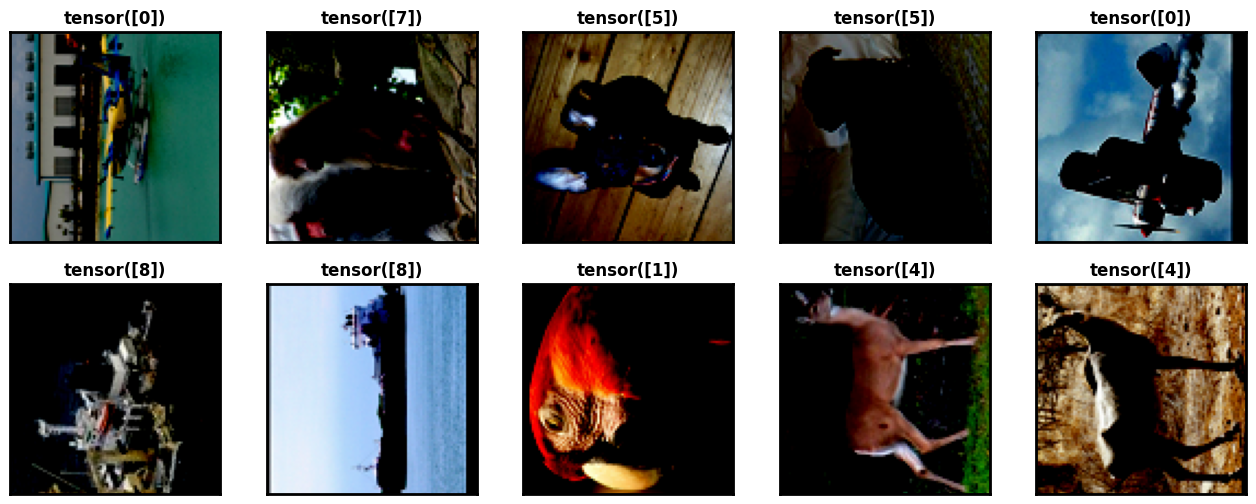

torch.Size([3, 96, 96])


In [6]:
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
axes = axes.flatten()
for i in range(10):
    axes[i].imshow(img[i].numpy().swapaxes(0, 2))

    axes[i].set_title(label[i].unique(), fontweight='bold')
    axes[i].spines[['top', 'bottom', 'left', 'right']].set_color('black')
    axes[i].spines[['top', 'bottom', 'left', 'right']].set_linewidth(2)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()
print(img[3].shape)

In [7]:
class AlexNet(nn.Module):
    def __init__(self, drop_out=True):
        super(AlexNet, self).__init__()
        self.convlayer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        if drop_out:
          self.fc1 = nn.Sequential(
              nn.Dropout(0.5),
              nn.Linear(256*6*6, 4096),
              nn.ReLU(inplace=True),
              nn.Dropout(0.5),
              nn.Linear(4096, 512),
              nn.ReLU(inplace=True),
              nn.Linear(512, 10)
          )
        else:
          self.fc1 = nn.Sequential(
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 10)
          )
    def forward(self, x):
        x = self.convlayer(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

model = AlexNet()
model2 = AlexNet(drop_out=False)
model.to(device)
model2.to(device)

AlexNet(
  (convlayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (fc1): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

90.26503312587738
79.25457906723022
74.86217892169952
71.8705929517746
67.96750771999359
65.63249862194061
62.077781677246094
60.18485152721405
56.98224580287933
55.556365609169006
53.32843589782715
51.374873638153076
49.4070188999176
45.46969962120056
45.85360997915268
41.22531169652939
40.51479870080948
45.55632436275482
37.44324642419815
33.96144896745682
32.48281019926071
27.974590212106705
24.26874467730522
25.64813858270645
23.15081375837326
22.30878335237503
21.273533433675766
19.53054541349411
13.440099254250526
10.534003629349172


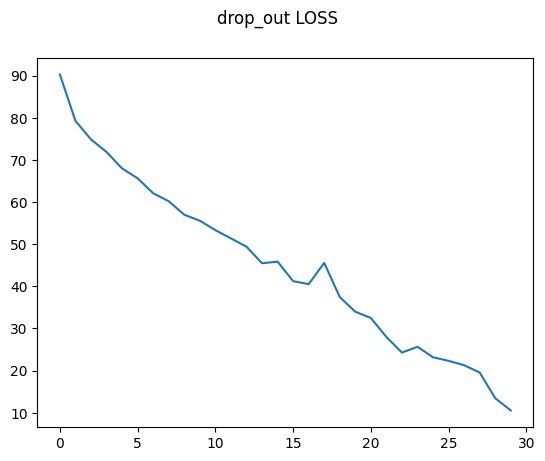

In [9]:
model.train()
epochs = 30
losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for batch_in, batch_out in train_loader:
        batch_in, batch_out = batch_in.to(device), batch_out.to(device)
        y_pred = model(batch_in)
        loss = criterion(y_pred, batch_out)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    losses.append(running_loss)
    print(running_loss)
    running_loss = 0.0

plt.plot(losses)
plt.suptitle('drop_out LOSS')
plt.show()

In [10]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
      for batch_in, batch_out in test_loader:
        batch_in, batch_out = batch_in.to(device), batch_out.to(device)
        outputs = model(batch_in)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_out.size(0)
        correct += (predicted == batch_out).sum().item()
print(100 * correct / total)

93.82


In [11]:
model.train()
epochs = 30
losses2 = []
for epoch in range(epochs):
    running_loss = 0.0
    for batch_in, batch_out in train_loader:
        batch_in, batch_out = batch_in.to(device), batch_out.to(device)
        y_pred = model2(batch_in)
        loss2 = criterion(y_pred, batch_out)
        
        optimizer2.zero_grad()
        loss2.backward()
        optimizer2.step()
        
        running_loss += loss2.item()
    losses2.append(running_loss)
    print(running_loss)
    running_loss = 0.0

90.59726929664612
79.25181984901428
73.8711166381836
68.77095031738281
66.48576521873474
63.68202888965607
60.68697166442871
59.226481437683105
57.71736454963684
55.44607627391815
57.963491678237915
53.080960392951965
50.1142863035202
47.5490380525589
46.82369989156723
43.19117087125778
37.59854233264923
35.24577420949936
33.88309943675995
29.997613072395325
27.23671120405197
29.08590567111969
23.548304200172424
23.505434900522232
25.18497109413147
14.835165068507195
14.484784066677094
10.70997279137373
10.611870415508747
10.463151387870312


In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
      for batch_in, batch_out in test_loader:
        batch_in, batch_out = batch_in.to(device), batch_out.to(device)
        outputs = model2(batch_in)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_out.size(0)
        correct += (predicted == batch_out).sum().item()
print(100 * correct / total)

90.42


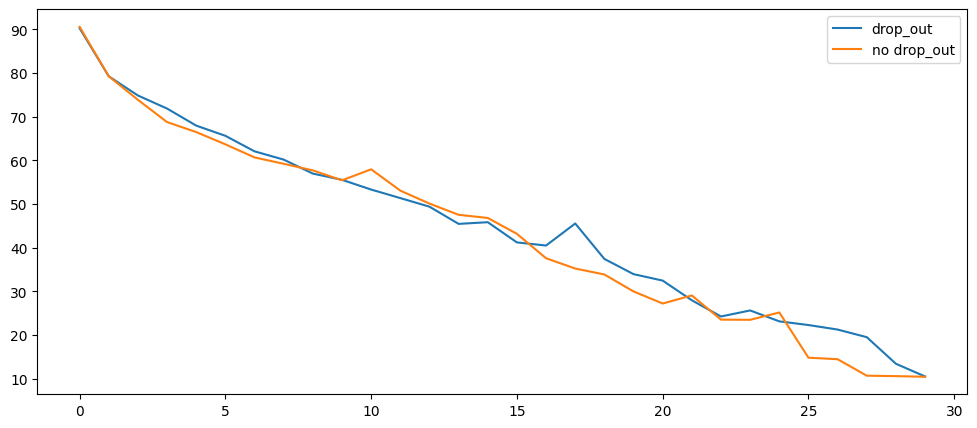

In [13]:
fig, axes = plt.subplots(1,1, figsize=(12,5))
axes.plot(losses, label='drop_out')
axes.plot(losses2, label='no drop_out')
axes.legend()
plt.show()